# Importation of libraries

In [1]:
import pandas as pd 
import numpy as np 
import re 
import nltk
from nltk.corpus import stopwords
from numpy import array 
import tensorflow as tf 
import seaborn as sns
import matplotlib.pyplot as plt

In [57]:
from keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM, BatchNormalization
from sklearn.model_selection import train_test_split

In [55]:
from keras_preprocessing.sequence import pad_sequences
from keras.optimizers import Adam

## Loading Dataset

In [4]:
food_reviews = pd.read_csv("Reviews.csv")
food_reviews

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


## Quick EDA 

In [5]:
food_reviews.shape

(568454, 10)

In [7]:
food_reviews[['Id', 'Text']]

,Id,Text
0,1,I have bought several of the Vitality canned d...
1,2,Product arrived labeled as Jumbo Salted Peanut...
2,3,This is a confection that has been around a fe...
3,4,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...
...,...,...
568449,568450,Great for sesame chicken..this is a good if no...
568450,568451,I'm disappointed with the flavor. The chocolat...
568451,568452,"These stars are small, so you can give 10-15 o..."
568452,568453,These are the BEST treats for training and rew...


In [8]:
#Checking if there are any missing values
food_reviews.isnull().values.any()

True

In [9]:
food_reviews.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [10]:
#Dropping the missing values 
food_reviews.dropna(inplace = True)

Text(0.5, 1.0, 'Count of Reviews by Stars')

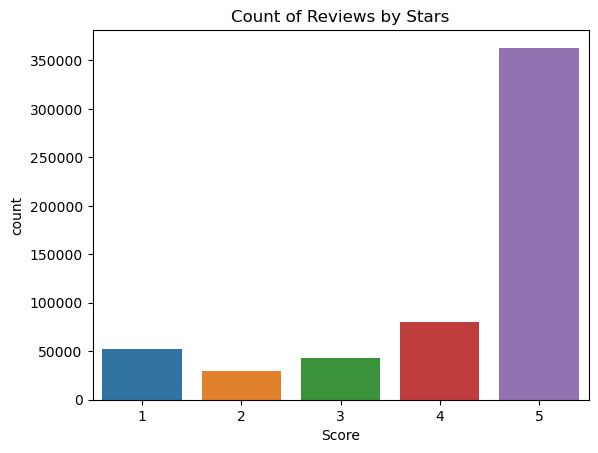

In [11]:
#Countplot of reviews per score 
fig = sns.countplot(x = 'Score', data = food_reviews)
fig.set_title('Count of Reviews by Stars')

## Feature Engineering

In [12]:
def sentiment(x):
    '''This function turns scores less than 3 to Negative, equal to 3 as Neutral and more than 3 as Positive'''
    if x < 3:
        return 'Negative'
    if x == 3:
        return 'Neutral'
    return ('Positive')

In [13]:
# Creating a new Series named Sentiment and mapping the Scores from the Score series to the relevant sentiments according to the sentiment function 
food_reviews['Sentiment'] = food_reviews['Score'].map(sentiment)

In [14]:
food_reviews

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive
...,...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...,Positive
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...,Negative
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",Positive
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...,Positive


In [15]:
#removing neutral reviews from the dataset
food_reviews = food_reviews.loc[food_reviews['Sentiment'] != 'Neutral']

([<matplotlib.patches.Wedge at 0x27c12dced60>,
 [Text(-0.9705623949005467, 0.5176955066493387, 'Positive'),
  Text(0.9705623949005463, -0.5176955066493393, 'Negative')],
 [Text(-0.5293976699457527, 0.2823793672632756, '84%'),
  Text(0.5293976699457524, -0.2823793672632759, '16%')])

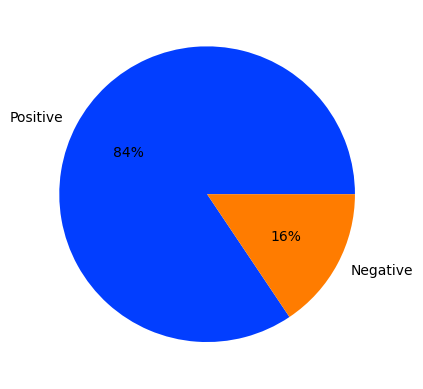

In [17]:
#Creating a Pie chart showing the distributions of sentiment between Positive and Negative
data = [len(food_reviews.loc[food_reviews['Sentiment'] == 'Positive']), len(food_reviews.loc[food_reviews['Sentiment'] == 'Negative'])]
palette_color = sns.color_palette('bright')
keys = ['Positive', 'Negative']
plt.pie(data, labels = keys, colors = palette_color, autopct='%.0f%%')

In [18]:
food_reviews.loc[food_reviews['Score'] == 2]['Text']

3         If you are looking for the secret ingredient i...
16        I love eating them and they are good for watch...
67        I purchased the Mango flavor, and to me it doe...
74        It is okay.  I would not go out of my way to b...
110       I was diappointed in the flavor and texture of...
                                ...                        
568416    When I ordered this chutney, it was supposed t...
568434    This soup is mostly broth. Although it has a k...
568435    It is mostly broth, with the advertised 3/4 cu...
568446    I had ordered some of these a few months back ...
568450    I'm disappointed with the flavor. The chocolat...
Name: Text, Length: 29743, dtype: object

In [19]:
food_reviews.iloc[:round(0.80 * food_reviews.shape[0]), :].drop('Sentiment', axis = 1).shape

(420618, 10)

#### Split the dataset into training and test for all of the models to be tested on the same reviews

In [20]:
X = food_reviews.drop('Sentiment', axis = 1)
y = food_reviews['Sentiment']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [22]:
y_train.value_counts()

Positive    354957
Negative     65661
Name: Sentiment, dtype: int64

In [23]:
y_test.value_counts()

Positive    88809
Negative    16346
Name: Sentiment, dtype: int64

([<matplotlib.patches.Wedge at 0x27c13770130>,
 [Text(-0.971418886826425, 0.5160865686267272, 'Positive'),
  Text(0.9714189109861797, -0.5160865231513266, 'Negative')],
 [Text(-0.529864847359868, 0.2815017647054875, '84%'),
  Text(0.5298648605379161, -0.2815017399007236, '16%')])

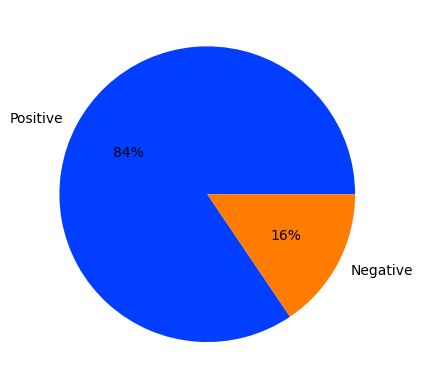

In [24]:
data = [88809, 16346]
palette_color = sns.color_palette('bright')
keys = ['Positive', 'Negative']
plt.pie(data, labels = keys, colors = palette_color, autopct='%.0f%%')

In [25]:
X_train

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
342242,342243,B000SWVPV8,A1G65XP8VHE7Y4,Judy Leffler,0,0,1,1339891200,Not coarse,I bought this with the intention of using it w...
159089,159090,B003AYEHSE,A1QKKMJUTF78QN,D. Harlow,0,0,5,1348358400,Very good product,You cant go wrong with this. Just freeze what ...
152213,152214,B004OVATO8,AKR4DH6WLF6GG,Linda Bulger,1,2,5,1317081600,A very yummy snack,These snack bars have a delicious tart berry t...
422268,422269,B000P03CNC,A1E8F0AYFXPCRB,Derrick,0,3,4,1309996800,"Very good, but not better then Haribo",Tried these out based on the reviews. Pros: T...
489634,489635,B0029XDZDK,A2NBUZAD5F5A92,"Ginger Edwards ""Southernbelle""",1,1,5,1278028800,Black Tiger Coffee,"I really like this coffee, I put it on auto sh..."
...,...,...,...,...,...,...,...,...,...,...
119672,119673,B004770O08,AKGP5SN4ZEUSX,R. LeBlanc,0,1,1,1330732800,"Green Mountain Coffee French ""Chemical"" Flavor",Having tried other instant Coffee/K-cups I'd h...
280981,280982,B000FFLHSY,A1SFTJNRZ95RKP,Helen H. Chung,2,2,4,1205193600,all 8 essential amino acids!,"hard to find all 8 in a natural, non-meat prod..."
395636,395637,B002N7DSP2,AUUMVZSHXVAK6,Kate,0,0,5,1281398400,PERFECT wafter cookie,DELICIOUS. In summer heat they get soggy rathe...
143257,143258,B0007A0AQM,A2O9N82I49GZ4P,C. Opal,0,0,5,1333324800,Great Product,Great product at a great price. My dog has man...


In [26]:
X_test

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
467468,467469,B001CWU9HE,A3HVO3WRHOVXNW,Nancy B. Kramer,0,0,5,1276732800,a great cracker for any occasion,Glutino Cheddar cheese crackers are one of the...
419757,419758,B0029ZAOW8,A2S4EBC3R0B1HK,RLRMRM,2,2,5,1248393600,this really works,5 hour energy really works. It makes you awake...
237225,237226,B0069LK5VS,A1KLQREEZ2SSRN,"TLS ""TLS""",0,0,5,1346371200,A++++,This beer is excellent if you enjoy something ...
148120,148121,B00415IRQO,A1KW0VVYVYGKH6,"Ruby ""Ruby""",7,8,4,1327104000,Great Flavor,I've resisted bouillon cubes in the past but m...
421716,421717,B0049J27JA,A36NUDST4Y5JBA,"D. S. HARDEN ""a movie fan""",0,0,4,1335830400,Black Forest Fruit Snacks Juicy Filled Centers...,Gang:<br /><br />I bought this as a back-up si...
...,...,...,...,...,...,...,...,...,...,...
200004,200005,B0046H312W,ARMGD218MFU0S,"T. Henry ""Tiff92""",1,1,5,1320624000,Best stock on the market,In my opinion this is the best stock on the ma...
26808,26809,B0018CG15W,A3HJ9SY1TH811Q,Lydia Vorpahl,1,2,1,1336176000,Is this bag on the recall list?,I purchased this bag of dog food and then brok...
159838,159839,B005VOONLW,AYWHCM0TJ4737,Ana Braga-Henebry,0,2,5,1336003200,You can have good coffee even you are having j...,"You may not be grinding the beans, but even if..."
116608,116609,B002YJ0118,A1O3Y2SBX7R896,Brian Demeter,1,2,4,1302739200,"Very good, but a little overboard on the salt",I have a Pasadena popcorn machine from The Gre...


## LSTM Data Preprocessing

In [27]:
food_reviews['Text'][2]

'This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis\' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.'

In [28]:
TAG_RE = re.compile(r'<[^>]+')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''
    
    return TAG_RE.sub('', text)

In [29]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Algy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more character long non_stopwords composed of A-Z & a-z only in lower case'''
    sentence = sen.lower()
    
    # Remove html tags
    sentence = remove_tags(sentence)
    
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    
    # Single character removal
    sentence = re.sub(r'\s+[a-zA-Z]\s+', ' ', sentence) # When we remove apostrophe from the word 'Mark's the apostrophe is replaced by an empty space
    
    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in
    
    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)
    
    return sentence

In [31]:
# Calling preprocessing_text function on food_reviews
X_train_lstm = []
sentences = list(X_train['Text'])
for sen in sentences:
    X_train_lstm.append(preprocess_text(sen))

In [32]:
X_train_lstm[2]

'snack bars delicious tart berry taste wonderful crunch surprising since ingredients essentially raw nuts berries held together sticky fruit goo fact stickiness could strike eat car rushing one place another many people contain calories indulge caution may suitable small children clean teeth well like well sticky mention love taste need delicious substantial snack low sodium cholesterol give bars try sampled flavors fact lot experience snack protein bars think stick one linda bulger '

##### Training our model on Positive and Negative data only because not all of the models can give the output of Neutrality

In [33]:
df_lstm_train = X_train

In [34]:
df_lstm_train

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
342242,342243,B000SWVPV8,A1G65XP8VHE7Y4,Judy Leffler,0,0,1,1339891200,Not coarse,I bought this with the intention of using it w...
159089,159090,B003AYEHSE,A1QKKMJUTF78QN,D. Harlow,0,0,5,1348358400,Very good product,You cant go wrong with this. Just freeze what ...
152213,152214,B004OVATO8,AKR4DH6WLF6GG,Linda Bulger,1,2,5,1317081600,A very yummy snack,These snack bars have a delicious tart berry t...
422268,422269,B000P03CNC,A1E8F0AYFXPCRB,Derrick,0,3,4,1309996800,"Very good, but not better then Haribo",Tried these out based on the reviews. Pros: T...
489634,489635,B0029XDZDK,A2NBUZAD5F5A92,"Ginger Edwards ""Southernbelle""",1,1,5,1278028800,Black Tiger Coffee,"I really like this coffee, I put it on auto sh..."
...,...,...,...,...,...,...,...,...,...,...
119672,119673,B004770O08,AKGP5SN4ZEUSX,R. LeBlanc,0,1,1,1330732800,"Green Mountain Coffee French ""Chemical"" Flavor",Having tried other instant Coffee/K-cups I'd h...
280981,280982,B000FFLHSY,A1SFTJNRZ95RKP,Helen H. Chung,2,2,4,1205193600,all 8 essential amino acids!,"hard to find all 8 in a natural, non-meat prod..."
395636,395637,B002N7DSP2,AUUMVZSHXVAK6,Kate,0,0,5,1281398400,PERFECT wafter cookie,DELICIOUS. In summer heat they get soggy rathe...
143257,143258,B0007A0AQM,A2O9N82I49GZ4P,C. Opal,0,0,5,1333324800,Great Product,Great product at a great price. My dog has man...


In [35]:
# Assigning y_train data for the LSTM model and changing the sentiments to 1s and 0s, Positive and Negative respectfully 
y_train_lstm = y_train
y_train_lstm = np.array(list(map(lambda x: 1 if x == 'Positive' else 0, y_train_lstm)))

In [36]:
y_train_lstm

array([0, 1, 1, ..., 1, 1, 1])

In [37]:
X_train_lstm

['bought intention using salt mill bother fine grind suppose coarse certainly would recommend product anyone ',
 'cant go wrong freeze wont using right away great flavor ',
 'snack bars delicious tart berry taste wonderful crunch surprising since ingredients essentially raw nuts berries held together sticky fruit goo fact stickiness could strike eat car rushing one place another many people contain calories indulge caution may suitable small children clean teeth well like well sticky mention love taste need delicious substantial snack low sodium cholesterol give bars try sampled flavors fact lot experience snack protein bars think stick one linda bulger ',
 'tried based reviews pros nice chewy without hard small packages make easier stop eating fruit juice cons flavors taste distinct tasting like haribo least opinion flavors pop haribos still good however dare say better black forest like black forest try like haribo stick haribo could also try life savers gummis life savers gummis wil

In [38]:
# Preparing the X_test data
X_test_lstm = []
sentences = list(X_test['Text'])
for sen in sentences:
    X_test_lstm.append(preprocess_text(sen))

In [39]:
X_test_lstm

['glutino cheddar cheese crackers one best crackers ever eaten light mild cheese flavor great soup cheese peanut butter salad drawback crackers expensive amount crackers received box ',
 ' hour energy really works makes awake aware without feeling jittery crash ',
 'beer excellent enjoy something big strong flavored enjoyed many types foods ',
 'resisted bouillon cubes past repertoire lacking answer flavor boullon amazing need lot low sodium boot helps oldies goodies chicken dumplings split pea soup chicken rice much better organic broth organic broth watery might well make highly recommend bouillon ',
 'gang bought back since ralphs run welch fruit snacks pleasantly surprised quality flavor snacks buy stock four stars snacks sale price amazon price absolutely unbelievable one star price get add shipping way ',
 'selection green mountain far favorite breakfast time aroma real french toast hearty taste full bodied coffee keep around popular also hard find amazon come us find place ',
 '

In [40]:
# Preparing the y_test label values 
y_test_lstm = y_test
y_test_lstm = np.array(list(map(lambda x: 1 if x == 'Positive' else 0, y_test_lstm)))

In [41]:
y_test_lstm

array([1, 1, 1, ..., 1, 1, 1])

## Preparing embedding layer

The next script will be for the embedding layer. The Embedding layer converts the textual data into numeric form.  It is then used as the first layer of the deep learning models in Keras

In [42]:
"""The Embedding layer expects the words to be in numeric form. Using Tokenizer function from keras.preprocessing.text library
    Using Tokenizer function from keras.preprocessing.text library method fit_on_text trains the tokenizer. The method texts_to_sequence converts sentence to their numeric form"""

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train_lstm)

X_train_embedded = word_tokenizer.texts_to_sequences(X_train_lstm)
X_test_embedded = word_tokenizer.texts_to_sequences(X_test_lstm)

In [43]:
X_train.head(1)['Text']

342242    I bought this with the intention of using it w...
Name: Text, dtype: object

In [44]:
X_train_embedded

[[46, 8004, 111, 114, 1461, 1415, 295, 1278, 1583, 3310, 622, 12, 56, 7, 328],
 [1624, 52, 451, 941, 1953, 111, 86, 205, 4, 8],
 [98,
  177,
  58,
  1162,
  1080,
  5,
  155,
  599,
  3318,
  51,
  96,
  3155,
  531,
  401,
  1335,
  2442,
  631,
  1231,
  207,
  5002,
  274,
  9773,
  57,
  6177,
  32,
  1198,
  9122,
  3,
  423,
  153,
  61,
  152,
  627,
  165,
  3603,
  2380,
  184,
  3195,
  102,
  857,
  431,
  387,
  27,
  1,
  27,
  1231,
  1052,
  10,
  5,
  109,
  58,
  3049,
  98,
  168,
  473,
  1303,
  62,
  177,
  31,
  2689,
  69,
  274,
  90,
  497,
  98,
  180,
  177,
  53,
  532,
  3,
  5359,
  26944],
 [22,
  523,
  225,
  2146,
  65,
  571,
  81,
  120,
  102,
  590,
  28,
  628,
  596,
  106,
  207,
  323,
  1975,
  69,
  5,
  2137,
  183,
  1,
  2626,
  262,
  623,
  69,
  588,
  21852,
  59,
  2,
  119,
  4186,
  92,
  30,
  234,
  4487,
  1,
  234,
  4487,
  31,
  1,
  2626,
  532,
  2626,
  57,
  17,
  31,
  355,
  8357,
  8708,
  355,
  8357,
  8708,
  1056,
 

In [45]:
import io
import json 

In [46]:
# Saving 
tokenizer_json = word_tokenizer.to_json()
with io.open('b3_tokenizer.json', 'w', encoding = 'utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii = False))

In [47]:
word_tokenizer.word_index

{'like': 1,
 'good': 2,
 'one': 3,
 'great': 4,
 'taste': 5,
 'coffee': 6,
 'product': 7,
 'flavor': 8,
 'tea': 9,
 'love': 10,
 'food': 11,
 'would': 12,
 'get': 13,
 'really': 14,
 'amazon': 15,
 'much': 16,
 'also': 17,
 'time': 18,
 'use': 19,
 'little': 20,
 'best': 21,
 'tried': 22,
 'buy': 23,
 'price': 24,
 'even': 25,
 'find': 26,
 'well': 27,
 'make': 28,
 'dog': 29,
 'better': 30,
 'try': 31,
 'eat': 32,
 'cup': 33,
 'first': 34,
 'chocolate': 35,
 'water': 36,
 'bag': 37,
 'sugar': 38,
 'found': 39,
 'used': 40,
 'free': 41,
 'sweet': 42,
 'made': 43,
 'day': 44,
 'drink': 45,
 'bought': 46,
 'two': 47,
 'way': 48,
 'box': 49,
 'store': 50,
 'since': 51,
 'go': 52,
 'think': 53,
 'tastes': 54,
 'order': 55,
 'recommend': 56,
 'could': 57,
 'delicious': 58,
 'still': 59,
 'know': 60,
 'many': 61,
 'give': 62,
 'favorite': 63,
 'got': 64,
 'nice': 65,
 'bit': 66,
 'never': 67,
 'every': 68,
 'flavors': 69,
 'mix': 70,
 'want': 71,
 'years': 72,
 'hot': 73,
 'dogs': 74,
 'stuf

In [48]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

93648

In [49]:
# Padding sentences with zeros for every sentence to have 100 length 
maxlen = 100

X_train_final = pad_sequences(X_train_embedded, padding = 'post', maxlen = maxlen)
X_test_final = pad_sequences(X_test_embedded, padding = 'post', maxlen = maxlen)

In [50]:
# Load GloVe word embeddings and create an Embeddings Dictionary 

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding = 'utf8')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype = 'float32')
    embeddings_dimensions = asarray(records[1:], dtype = 'float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [51]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [52]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.2687    ,  0.81708002,  0.69896001, ..., -0.40110001,
         0.74656999,  0.31121999],
       [-0.030769  ,  0.11993   ,  0.53908998, ..., -0.52877998,
         0.17584001,  1.06500006],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [53]:
embedding_matrix.shape

(93648, 100)

In [54]:
from keras.layers import LSTM

In [55]:
#Creating the LSTM model
lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights = [embedding_matrix], input_length = maxlen, trainable = False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation = 'sigmoid'))

In [56]:
#Compiling the model 
lstm_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9364800   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 9,482,177
Trainable params: 117,377
Non-trainable params: 9,364,800
_________________________________________________________________
None


In [57]:
lstm_model_history = lstm_model.fit(X_train_final, y_train_lstm, batch_size = 128, epochs = 6, verbose = 1, validation_split = 0.2)

Epoch 1/6
2629/2629 [==============================] - 796s 299ms/step - loss: 0.3693 - acc: 0.8623 - val_loss: 0.2329 - val_acc: 0.9071
Epoch 2/6
2629/2629 [==============================] - 767s 292ms/step - loss: 0.2144 - acc: 0.9145 - val_loss: 0.1960 - val_acc: 0.9236
Epoch 3/6
2629/2629 [==============================] - 771s 293ms/step - loss: 0.1812 - acc: 0.9289 - val_loss: 0.1759 - val_acc: 0.9322
Epoch 4/6
2629/2629 [==============================] - 777s 295ms/step - loss: 0.1575 - acc: 0.9394 - val_loss: 0.1586 - val_acc: 0.9393
Epoch 5/6
2629/2629 [==============================] - 821s 312ms/step - loss: 0.1384 - acc: 0.9477 - val_loss: 0.1516 - val_acc: 0.9435
Epoch 6/6
2629/2629 [==============================] - 831s 316ms/step - loss: 0.1206 - acc: 0.9554 - val_loss: 0.1519 - val_acc: 0.9459


In [59]:
lstm_model_history.history

{'loss': [0.36928996443748474,
  0.21439163386821747,
  0.18119443953037262,
  0.1575383096933365,
  0.1384209245443344,
  0.12062377482652664],
 'acc': [0.8622828125953674,
  0.9144887924194336,
  0.9288724064826965,
  0.9394045472145081,
  0.9476780891418457,
  0.9553899765014648],
 'val_loss': [0.232936829328537,
  0.1959751397371292,
  0.17585812509059906,
  0.15859748423099518,
  0.15158092975616455,
  0.15189777314662933],
 'val_acc': [0.9070895314216614,
  0.9236246347427368,
  0.9322310090065002,
  0.9392682313919067,
  0.9434763193130493,
  0.9459131956100464]}

In [60]:
history_df = pd.DataFrame(lstm_model_history.history)

In [61]:
history_df

,loss,acc,val_loss,val_acc
0,0.369290,0.862283,0.232937,0.907090
1,0.214392,0.914489,0.195975,0.923625
2,0.181194,0.928872,0.175858,0.932231
3,0.157538,0.939405,0.158597,0.939268
4,0.138421,0.947678,0.151581,0.943476
5,0.120624,0.955390,0.151898,0.945913


In [64]:
#Saving history metrics of model
history_df.to_csv('history_lstm.csv')

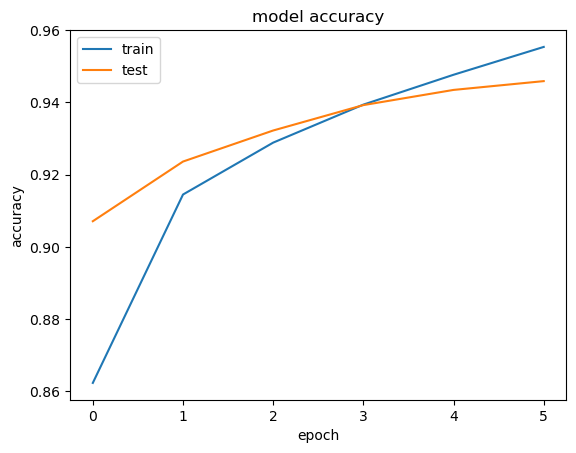

In [66]:
#Plotting a graph of the model training and test accuracies
plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

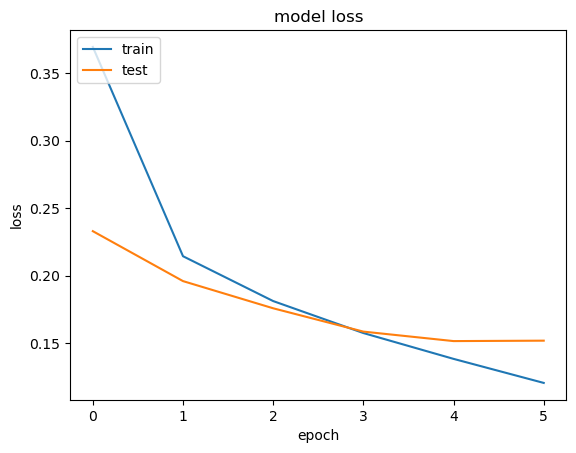

In [67]:
#Plotting a training and test loss graph 
plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights = [embedding_matrix], input_length = maxlen, trainable = False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation = 'sigmoid'))

In [201]:
#Saving the trained model
lstm_model.save(f"./c1_lstm_model-3", save_format = 'h5')

# Experimentation

In [58]:
#Trying out a different architecture of LSTM model
lstm_model_2 = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights = [embedding_matrix], input_length = maxlen, trainable = False)
lstm_model_2.add(embedding_layer)
lstm_model_2.add(LSTM(256))
lstm_model_2.add(Dropout(0.5))
lstm_model_2.add(BatchNormalization())
lstm_model_2.add(Dropout(0.5))
lstm_model_2.add(Dense(512, activation = 'relu'))
lstm_model_2.add(Dropout(0.5))
lstm_model_2.add(BatchNormalization())
lstm_model_2.add(Dropout(0.5))
lstm_model_2.add(Dense(1, activation = 'sigmoid'))

In [59]:
#Compiling the model
lstm_model_2.compile(optimizer = Adam(0.001), loss = 'categorical_crossentropy', metrics = ['acc'])
print(lstm_model_2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9364800   
                                                                 
 lstm_1 (LSTM)               (None, 256)               365568    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 512)               131584    
                                                      

# Model #2

In [60]:
lstm_model_2_history = lstm_model_2.fit(X_train_final, y_train_lstm, batch_size = 128, epochs = 6, verbose = 1, validation_split = 0.2)

Epoch 1/6


D:\Anaconda\envs\pytorch_attempt\lib\site-packages\tensorflow\python\util\dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


2629/2629 [==============================] - 3222s 1s/step - loss: 0.0000e+00 - acc: 0.1970 - val_loss: 0.0000e+00 - val_acc: 0.1553
Epoch 2/6
2629/2629 [==============================] - 2994s 1s/step - loss: 0.0000e+00 - acc: 0.1563 - val_loss: 0.0000e+00 - val_acc: 0.1553
Epoch 3/6
2629/2629 [==============================] - 2836s 1s/step - loss: 0.0000e+00 - acc: 0.1563 - val_loss: 0.0000e+00 - val_acc: 0.1553
Epoch 4/6
2629/2629 [==============================] - 2789s 1s/step - loss: 0.0000e+00 - acc: 0.1563 - val_loss: 0.0000e+00 - val_acc: 0.1553
Epoch 5/6
2629/2629 [==============================] - 2761s 1s/step - loss: 0.0000e+00 - acc: 0.1563 - val_loss: 0.0000e+00 - val_acc: 0.1553
Epoch 6/6
2629/2629 [==============================] - 2864s 1s/step - loss: 0.0000e+00 - acc: 0.1563 - val_loss: 0.0000e+00 - val_acc: 0.1553


# Model #3

In [61]:
#Changing the hyperparameters of the first model
lstm_model_3 = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights = [embedding_matrix], input_length = maxlen, trainable = False)

lstm_model_3.add(embedding_layer)
lstm_model_3.add(LSTM(258))
lstm_model_3.add(Dense(1, activation = 'sigmoid'))

In [62]:
#Compiling the model 
lstm_model_3.compile(optimizer = Adam(0.001), loss = 'binary_crossentropy', metrics = ['acc'])
print(lstm_model_3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          9364800   
                                                                 
 lstm_2 (LSTM)               (None, 258)               370488    
                                                                 
 dense_2 (Dense)             (None, 1)                 259       
                                                                 
Total params: 9,735,547
Trainable params: 370,747
Non-trainable params: 9,364,800
_________________________________________________________________
None


In [63]:
lstm_model_3_history = lstm_model_3.fit(X_train_final, y_train_lstm, batch_size = 64, epochs = 6, verbose = 1, validation_split = 0.2)

Epoch 1/6
5258/5258 [==============================] - 2978s 565ms/step - loss: 0.3482 - acc: 0.8691 - val_loss: 0.2167 - val_acc: 0.9130
Epoch 2/6
5258/5258 [==============================] - 3209s 610ms/step - loss: 0.1958 - acc: 0.9231 - val_loss: 0.1715 - val_acc: 0.9326
Epoch 3/6
5258/5258 [==============================] - 4012s 763ms/step - loss: 0.1553 - acc: 0.9405 - val_loss: 0.1538 - val_acc: 0.9415
Epoch 4/6
5258/5258 [==============================] - 4346s 827ms/step - loss: 0.1244 - acc: 0.9535 - val_loss: 0.1408 - val_acc: 0.9487
Epoch 5/6
5258/5258 [==============================] - 4030s 766ms/step - loss: 0.0981 - acc: 0.9649 - val_loss: 0.1401 - val_acc: 0.9506
Epoch 6/6
5258/5258 [==============================] - 3810s 725ms/step - loss: 0.0760 - acc: 0.9734 - val_loss: 0.1523 - val_acc: 0.9501


In [66]:
history_df_2 = pd.DataFrame(lstm_model_3_history.history)
history_df_2.to_csv('history_lstm_model_3')

# Model #4

In [67]:
lstm_model_4 = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights = [embedding_matrix], input_length = maxlen, trainable = False)

lstm_model_4.add(embedding_layer)
lstm_model_4.add(LSTM(256))

lstm_model_4.add(Dense(1, activation = 'sigmoid'))

In [68]:
lstm_model_4.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
print(lstm_model_4.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          9364800   
                                                                 
 lstm_3 (LSTM)               (None, 256)               365568    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 9,730,625
Trainable params: 365,825
Non-trainable params: 9,364,800
_________________________________________________________________
None


In [ ]:
lstm_model_4_history = lstm_model_4.fit(X_train_final, y_train_lstm, batch_size = 32, epochs = 6, verbose = 1, validation_split = 0.2)

Epoch 1/6
 7649/10516 [====================>.........] - ETA: 18:26 - loss: 0.0000e+00 - acc: 0.1567

In [67]:
#Loading model 
from keras.models import load_model
pretrained_lstm_model = load_model('c1_lstm_model-3')
pretrained_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9364800   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9,482,177
Trainable params: 117,377
Non-trainable params: 9,364,800
_________________________________________________________________


In [68]:
X_test_final

array([[ 4271,  1244,   266, ...,     0,     0,     0],
       [  679,   282,    14, ...,     0,     0,     0],
       [ 1227,   170,   121, ...,     0,     0,     0],
       ...,
       [  184,  3159,   265, ...,     0,     0,     0],
       [23316,   273,   418, ...,     0,     0,     0],
       [  143,    22,  1630, ...,    82,     4,   387]])

In [69]:
len(X_test_final)

105155

In [70]:
# Making the predictions on test data with LSTM model 
test_sentiments = pretrained_lstm_model.predict(X_test_final)

3287/3287 [==============================] - 208s 60ms/step


In [71]:
test_sentiments.shape

(105155, 1)

In [72]:
test_sentiments[:10]

array([[0.9986508 ],
       [0.99775517],
       [0.9964848 ],
       [0.9931591 ],
       [0.9690502 ],
       [0.998866  ],
       [0.9969052 ],
       [0.93682426],
       [0.9936867 ],
       [0.00441031]], dtype=float32)

In [73]:
#Copying all the results in a single array 
test_sentiments_array = []
for i in range(len(test_sentiments)):
    test_sentiments_array.append(test_sentiments[i][0])

In [74]:
#Mapping sentiment of scores of LSTM to Positive and Negative
converted_lstm_sentiments = ['Positive' if x >= 0.50 else 'Negative' for x in test_sentiments]

In [75]:
len(test_sentiments_array)

105155

In [76]:
len(converted_lstm_sentiments)

105155

In [77]:
lstm_df = X_test.copy()

In [78]:
lstm_df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
467468,467469,B001CWU9HE,A3HVO3WRHOVXNW,Nancy B. Kramer,0,0,5,1276732800,a great cracker for any occasion,Glutino Cheddar cheese crackers are one of the...
419757,419758,B0029ZAOW8,A2S4EBC3R0B1HK,RLRMRM,2,2,5,1248393600,this really works,5 hour energy really works. It makes you awake...
237225,237226,B0069LK5VS,A1KLQREEZ2SSRN,"TLS ""TLS""",0,0,5,1346371200,A++++,This beer is excellent if you enjoy something ...
148120,148121,B00415IRQO,A1KW0VVYVYGKH6,"Ruby ""Ruby""",7,8,4,1327104000,Great Flavor,I've resisted bouillon cubes in the past but m...
421716,421717,B0049J27JA,A36NUDST4Y5JBA,"D. S. HARDEN ""a movie fan""",0,0,4,1335830400,Black Forest Fruit Snacks Juicy Filled Centers...,Gang:<br /><br />I bought this as a back-up si...
...,...,...,...,...,...,...,...,...,...,...
200004,200005,B0046H312W,ARMGD218MFU0S,"T. Henry ""Tiff92""",1,1,5,1320624000,Best stock on the market,In my opinion this is the best stock on the ma...
26808,26809,B0018CG15W,A3HJ9SY1TH811Q,Lydia Vorpahl,1,2,1,1336176000,Is this bag on the recall list?,I purchased this bag of dog food and then brok...
159838,159839,B005VOONLW,AYWHCM0TJ4737,Ana Braga-Henebry,0,2,5,1336003200,You can have good coffee even you are having j...,"You may not be grinding the beans, but even if..."
116608,116609,B002YJ0118,A1O3Y2SBX7R896,Brian Demeter,1,2,4,1302739200,"Very good, but a little overboard on the salt",I have a Pasadena popcorn machine from The Gre...


In [79]:
#Creating new Series of Mapped out LSTM sentiments
lstm_df['Polar_sentiments'] = converted_lstm_sentiments

In [80]:
lstm_df['lstm_compound'] = test_sentiments_array

In [81]:
lstm_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Polar_sentiments,lstm_compound
467468,467469,B001CWU9HE,A3HVO3WRHOVXNW,Nancy B. Kramer,0,0,5,1276732800,a great cracker for any occasion,Glutino Cheddar cheese crackers are one of the...,Positive,0.998651
419757,419758,B0029ZAOW8,A2S4EBC3R0B1HK,RLRMRM,2,2,5,1248393600,this really works,5 hour energy really works. It makes you awake...,Positive,0.997755
237225,237226,B0069LK5VS,A1KLQREEZ2SSRN,"TLS ""TLS""",0,0,5,1346371200,A++++,This beer is excellent if you enjoy something ...,Positive,0.996485
148120,148121,B00415IRQO,A1KW0VVYVYGKH6,"Ruby ""Ruby""",7,8,4,1327104000,Great Flavor,I've resisted bouillon cubes in the past but m...,Positive,0.993159
421716,421717,B0049J27JA,A36NUDST4Y5JBA,"D. S. HARDEN ""a movie fan""",0,0,4,1335830400,Black Forest Fruit Snacks Juicy Filled Centers...,Gang:<br /><br />I bought this as a back-up si...,Positive,0.969050


Text(0.5, 1.0, 'Compound Score by Amazon Star Review for LSTM')

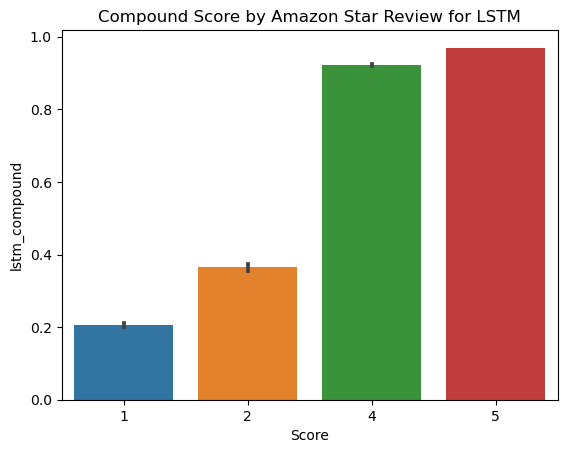

In [62]:
ax = sns.barplot(data = lstm_df, x = 'Score', y = 'lstm_compound')
ax.set_title('Compound Score by Amazon Star Review for LSTM')

## Scoring with VADER model

In [82]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm 

In [83]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Algy\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [84]:
sia.polarity_scores('I am so happy')

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}

In [85]:
sia.polarity_scores('This is the worst thing ever')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [76]:
X_test.loc[food_reviews['Score'] == 3].shape[0]

0

In [79]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [86]:
# Test Running the polarity score on the test data 
vader_res = {}
for i, row in tqdm(X_test.iterrows(), total = len(X_test)):
    text = row['Text']
    myid = row['Id']
    vader_res[myid] = sia.polarity_scores(text)

  0%|          | 0/105155 [00:00<?, ?it/s]

In [87]:
vader_res

{467469: {'neg': 0.0, 'neu': 0.841, 'pos': 0.159, 'compound': 0.8519},
 419758: {'neg': 0.337, 'neu': 0.597, 'pos': 0.066, 'compound': -0.7472},
 237226: {'neg': 0.0, 'neu': 0.526, 'pos': 0.474, 'compound': 0.926},
 148121: {'neg': 0.017, 'neu': 0.737, 'pos': 0.247, 'compound': 0.9682},
 421717: {'neg': 0.031, 'neu': 0.894, 'pos': 0.075, 'compound': 0.4753},
 419111: {'neg': 0.029, 'neu': 0.835, 'pos': 0.135, 'compound': 0.7245},
 203929: {'neg': 0.0, 'neu': 0.625, 'pos': 0.375, 'compound': 0.9584},
 241719: {'neg': 0.048, 'neu': 0.887, 'pos': 0.066, 'compound': 0.2617},
 163810: {'neg': 0.106, 'neu': 0.8, 'pos': 0.094, 'compound': 0.3863},
 104750: {'neg': 0.08, 'neu': 0.831, 'pos': 0.089, 'compound': 0.2091},
 560378: {'neg': 0.057, 'neu': 0.752, 'pos': 0.191, 'compound': 0.7639},
 296068: {'neg': 0.071, 'neu': 0.76, 'pos': 0.168, 'compound': 0.9463},
 54290: {'neg': 0.142, 'neu': 0.623, 'pos': 0.235, 'compound': 0.686},
 249021: {'neg': 0.0, 'neu': 0.734, 'pos': 0.266, 'compound': 0

In [88]:
# Putting the results in DataFrame
vaders = pd.DataFrame(vader_res).T
vaders = vaders.reset_index().rename(columns = {'index': 'Id'})
vaders = vaders.merge(X_test, how = 'left')

In [89]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,467469,0.000,0.841,0.159,0.8519,B001CWU9HE,A3HVO3WRHOVXNW,Nancy B. Kramer,0,0,5,1276732800,a great cracker for any occasion,Glutino Cheddar cheese crackers are one of the...
1,419758,0.337,0.597,0.066,-0.7472,B0029ZAOW8,A2S4EBC3R0B1HK,RLRMRM,2,2,5,1248393600,this really works,5 hour energy really works. It makes you awake...
2,237226,0.000,0.526,0.474,0.9260,B0069LK5VS,A1KLQREEZ2SSRN,"TLS ""TLS""",0,0,5,1346371200,A++++,This beer is excellent if you enjoy something ...
3,148121,0.017,0.737,0.247,0.9682,B00415IRQO,A1KW0VVYVYGKH6,"Ruby ""Ruby""",7,8,4,1327104000,Great Flavor,I've resisted bouillon cubes in the past but m...
4,421717,0.031,0.894,0.075,0.4753,B0049J27JA,A36NUDST4Y5JBA,"D. S. HARDEN ""a movie fan""",0,0,4,1335830400,Black Forest Fruit Snacks Juicy Filled Centers...,Gang:<br /><br />I bought this as a back-up si...


In [90]:
vaders.rename(columns = {'neg':'vader_neg', 'pos':'vader_pos','compound':'vader_compound'}, inplace = True)

In [91]:
vaders

,Id,vader_neg,neu,vader_pos,vader_compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,467469,0.000,0.841,0.159,0.8519,B001CWU9HE,A3HVO3WRHOVXNW,Nancy B. Kramer,0,0,5,1276732800,a great cracker for any occasion,Glutino Cheddar cheese crackers are one of the...
1,419758,0.337,0.597,0.066,-0.7472,B0029ZAOW8,A2S4EBC3R0B1HK,RLRMRM,2,2,5,1248393600,this really works,5 hour energy really works. It makes you awake...
2,237226,0.000,0.526,0.474,0.9260,B0069LK5VS,A1KLQREEZ2SSRN,"TLS ""TLS""",0,0,5,1346371200,A++++,This beer is excellent if you enjoy something ...
3,148121,0.017,0.737,0.247,0.9682,B00415IRQO,A1KW0VVYVYGKH6,"Ruby ""Ruby""",7,8,4,1327104000,Great Flavor,I've resisted bouillon cubes in the past but m...
4,421717,0.031,0.894,0.075,0.4753,B0049J27JA,A36NUDST4Y5JBA,"D. S. HARDEN ""a movie fan""",0,0,4,1335830400,Black Forest Fruit Snacks Juicy Filled Centers...,Gang:<br /><br />I bought this as a back-up si...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105150,200005,0.000,0.719,0.281,0.9559,B0046H312W,ARMGD218MFU0S,"T. Henry ""Tiff92""",1,1,5,1320624000,Best stock on the market,In my opinion this is the best stock on the ma...
105151,26809,0.069,0.890,0.041,-0.1779,B0018CG15W,A3HJ9SY1TH811Q,Lydia Vorpahl,1,2,1,1336176000,Is this bag on the recall list?,I purchased this bag of dog food and then brok...
105152,159839,0.000,0.721,0.279,0.9716,B005VOONLW,AYWHCM0TJ4737,Ana Braga-Henebry,0,2,5,1336003200,You can have good coffee even you are having j...,"You may not be grinding the beans, but even if..."
105153,116609,0.000,0.891,0.109,0.9143,B002YJ0118,A1O3Y2SBX7R896,Brian Demeter,1,2,4,1302739200,"Very good, but a little overboard on the salt",I have a Pasadena popcorn machine from The Gre...


In [92]:
# Appending the VADER compound scores in a list
compound_vader = []
for i, value in vader_res.items():
    compound_vader.append(value['compound'])

In [93]:
compound_vader

[0.8519,
 -0.7472,
 0.926,
 0.9682,
 0.4753,
 0.7245,
 0.9584,
 0.2617,
 0.3863,
 0.2091,
 0.7639,
 0.9463,
 0.686,
 0.7841,
 -0.0772,
 0.8519,
 0.6597,
 0.7184,
 0.34,
 0.4939,
 0.0,
 0.5859,
 0.9349,
 0.9299,
 -0.7235,
 0.91,
 0.9927,
 0.9875,
 -0.3211,
 0.6793,
 0.6369,
 0.7808,
 0.8399,
 0.95,
 0.9238,
 0.9811,
 0.8689,
 0.9405,
 0.9554,
 0.5095,
 0.9117,
 0.802,
 0.9918,
 0.8591,
 0.8979,
 0.9079,
 0.902,
 0.8665,
 0.8898,
 0.296,
 0.8785,
 0.9324,
 0.9305,
 0.69,
 0.5778,
 0.9401,
 0.9167,
 0.3602,
 0.9504,
 0.8553,
 0.8225,
 0.8658,
 0.8478,
 0.8834,
 -0.8777,
 0.8858,
 0.9694,
 -0.9393,
 0.9918,
 0.9032,
 0.7263,
 0.8983,
 0.8485,
 0.8807,
 -0.2484,
 0.7433,
 0.9022,
 0.8916,
 0.9205,
 0.2647,
 0.9542,
 0.9853,
 0.7697,
 0.984,
 0.915,
 0.5817,
 0.5707,
 -0.4153,
 0.8973,
 0.8221,
 0.7654,
 0.7339,
 0.886,
 0.7184,
 0.9922,
 0.9112,
 0.9712,
 0.8883,
 0.988,
 0.081,
 0.938,
 0.8268,
 0.8225,
 0.9272,
 -0.3804,
 0.891,
 0.9062,
 0.9774,
 0.1129,
 0.6486,
 0.9741,
 0.8122,
 -0.62

In [94]:
#Mapping VADER compound sentiment 
vader_sentiment = ["Positive" if x >= 0 else "Negative" for x in compound_vader]

In [95]:
X_test_vader = X_test.copy()

In [96]:
X_test_vader["Vader_sentiment"] = vader_sentiment

In [97]:
X_test_vader

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Vader_sentiment
467468,467469,B001CWU9HE,A3HVO3WRHOVXNW,Nancy B. Kramer,0,0,5,1276732800,a great cracker for any occasion,Glutino Cheddar cheese crackers are one of the...,Positive
419757,419758,B0029ZAOW8,A2S4EBC3R0B1HK,RLRMRM,2,2,5,1248393600,this really works,5 hour energy really works. It makes you awake...,Negative
237225,237226,B0069LK5VS,A1KLQREEZ2SSRN,"TLS ""TLS""",0,0,5,1346371200,A++++,This beer is excellent if you enjoy something ...,Positive
148120,148121,B00415IRQO,A1KW0VVYVYGKH6,"Ruby ""Ruby""",7,8,4,1327104000,Great Flavor,I've resisted bouillon cubes in the past but m...,Positive
421716,421717,B0049J27JA,A36NUDST4Y5JBA,"D. S. HARDEN ""a movie fan""",0,0,4,1335830400,Black Forest Fruit Snacks Juicy Filled Centers...,Gang:<br /><br />I bought this as a back-up si...,Positive
...,...,...,...,...,...,...,...,...,...,...,...
200004,200005,B0046H312W,ARMGD218MFU0S,"T. Henry ""Tiff92""",1,1,5,1320624000,Best stock on the market,In my opinion this is the best stock on the ma...,Positive
26808,26809,B0018CG15W,A3HJ9SY1TH811Q,Lydia Vorpahl,1,2,1,1336176000,Is this bag on the recall list?,I purchased this bag of dog food and then brok...,Negative
159838,159839,B005VOONLW,AYWHCM0TJ4737,Ana Braga-Henebry,0,2,5,1336003200,You can have good coffee even you are having j...,"You may not be grinding the beans, but even if...",Positive
116608,116609,B002YJ0118,A1O3Y2SBX7R896,Brian Demeter,1,2,4,1302739200,"Very good, but a little overboard on the salt",I have a Pasadena popcorn machine from The Gre...,Positive


Text(0.5, 1.0, 'Compound Score by Amazon Start Review')

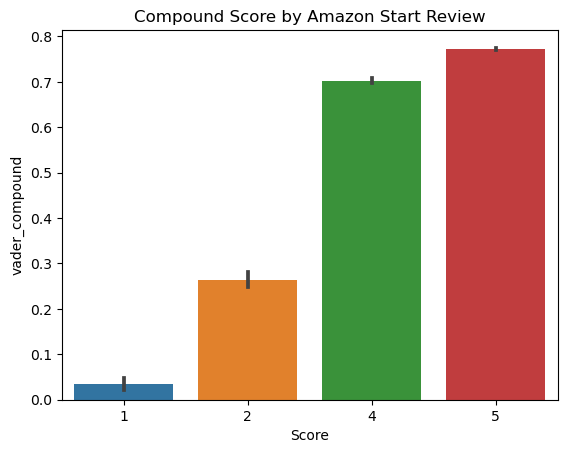

In [92]:
ax = sns.barplot(data = vaders, x = 'Score', y = 'vader_compound')
ax.set_title('Compound Score by Amazon Start Review')

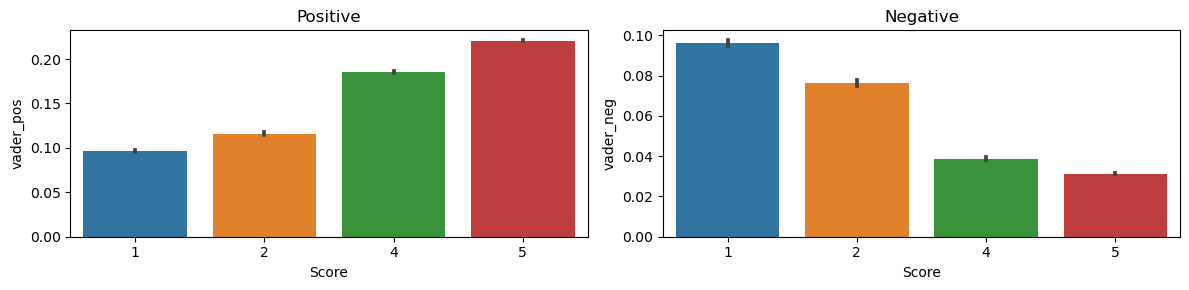

In [93]:
fig, axs = plt.subplots(1, 2, figsize = (12, 3))
sns.barplot(data = vaders, x = 'Score', y = 'vader_pos', ax = axs[0])
sns.barplot(data = vaders, x = 'Score', y = 'vader_neg', ax = axs[1])
axs[0].set_title('Positive')
axs[1].set_title('Negative')
plt.tight_layout()

## Roberta Pretrained Model

In [98]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [99]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [100]:
example = "This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go"

In [101]:
'''Code that will tokenize the example text and have model predict an outcome on it and output the results in the form of a dictionary'''
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
}

print(scores_dict)

{'roberta_neg': 0.97755194, 'roberta_neu': 0.019648988, 'roberta_pos': 0.0027990106}


In [102]:
def polarity_scores_roberta(example):
    '''This function will tokenize the text and have the model predict the sentiment on it and then output the results in the form of a dictionary'''
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

In [103]:
X_test.head(100)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
467468,467469,B001CWU9HE,A3HVO3WRHOVXNW,Nancy B. Kramer,0,0,5,1276732800,a great cracker for any occasion,Glutino Cheddar cheese crackers are one of the...
419757,419758,B0029ZAOW8,A2S4EBC3R0B1HK,RLRMRM,2,2,5,1248393600,this really works,5 hour energy really works. It makes you awake...
237225,237226,B0069LK5VS,A1KLQREEZ2SSRN,"TLS ""TLS""",0,0,5,1346371200,A++++,This beer is excellent if you enjoy something ...
148120,148121,B00415IRQO,A1KW0VVYVYGKH6,"Ruby ""Ruby""",7,8,4,1327104000,Great Flavor,I've resisted bouillon cubes in the past but m...
421716,421717,B0049J27JA,A36NUDST4Y5JBA,"D. S. HARDEN ""a movie fan""",0,0,4,1335830400,Black Forest Fruit Snacks Juicy Filled Centers...,Gang:<br /><br />I bought this as a back-up si...
...,...,...,...,...,...,...,...,...,...,...
258855,258856,B000S4D09G,A3UE68LUPLVYQ,"Dolly, Pool Girl",3,3,5,1226966400,spaetzle noodles,these are so yummy! Glad I bought lots of bag...
406163,406164,B0032GMRBO,A2OBW9JVW3FE4R,tristan421,2,2,5,1286928000,This is my favorite nature valley flavor ever,"I love chocolate, I love oats and I love crunc..."
283598,283599,B008MNDQPI,A1W3TUKVZW0NE3,John M. Tucker,3,36,1,1173312000,kadoya pure sesame oil,Ads a very pleasant taste to my stir fry exper...
138603,138604,B001E5E0Z6,A30VOEIL6L2DOF,"JPDMyers ""JPDMyers""",2,2,5,1328918400,THE BEST!!,I have loved chocolate milk my entire life and...


In [104]:
X_test.shape

(105155, 10)

In [105]:
'''This sequence of code makes sentiment predictions with both the Vader and RoBERTa models 
   and creates a dictionary of the results '''
roberta_res = {}
for i, row in tqdm(X_test.head(5000).iterrows(), total = len(X_test.head(5000))):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        roberta_res[myid] = both
        
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/5000 [00:00<?, ?it/s]

Broke for id 261233
Broke for id 40058
Broke for id 209102
Broke for id 271179
Broke for id 260660
Broke for id 379246
Broke for id 58231
Broke for id 231880
Broke for id 84415
Broke for id 29110
Broke for id 562166
Broke for id 353151
Broke for id 383628
Broke for id 396987
Broke for id 25582
Broke for id 383867
Broke for id 342542
Broke for id 70717
Broke for id 252365
Broke for id 99317
Broke for id 323243
Broke for id 25473
Broke for id 511560
Broke for id 136892
Broke for id 561348
Broke for id 475956
Broke for id 356387
Broke for id 66855
Broke for id 321262
Broke for id 278296
Broke for id 528261
Broke for id 248686
Broke for id 300288
Broke for id 274231
Broke for id 438985
Broke for id 65639
Broke for id 437095
Broke for id 168270
Broke for id 96836
Broke for id 171578
Broke for id 89737
Broke for id 231363
Broke for id 360683
Broke for id 13282
Broke for id 231804
Broke for id 528706
Broke for id 82789


In [108]:
roberta_res

{467469: {'vader_neg': 0.0,
  'vader_neu': 0.841,
  'vader_pos': 0.159,
  'vader_compound': 0.8519,
  'roberta_neg': 0.004975279,
  'roberta_neu': 0.02270869,
  'roberta_pos': 0.972316},
 419758: {'vader_neg': 0.337,
  'vader_neu': 0.597,
  'vader_pos': 0.066,
  'vader_compound': -0.7472,
  'roberta_neg': 0.00586993,
  'roberta_neu': 0.09074225,
  'roberta_pos': 0.9033878},
 237226: {'vader_neg': 0.0,
  'vader_neu': 0.526,
  'vader_pos': 0.474,
  'vader_compound': 0.926,
  'roberta_neg': 0.0012957836,
  'roberta_neu': 0.012677672,
  'roberta_pos': 0.9860265},
 148121: {'vader_neg': 0.017,
  'vader_neu': 0.737,
  'vader_pos': 0.247,
  'vader_compound': 0.9682,
  'roberta_neg': 0.0073679653,
  'roberta_neu': 0.034813665,
  'roberta_pos': 0.9578184},
 421717: {'vader_neg': 0.031,
  'vader_neu': 0.894,
  'vader_pos': 0.075,
  'vader_compound': 0.4753,
  'roberta_neg': 0.0061075487,
  'roberta_neu': 0.026144821,
  'roberta_pos': 0.9677477},
 419111: {'vader_neg': 0.029,
  'vader_neu': 0.835

In [109]:
len(roberta_res)

4953

In [110]:
#List of the rows which had errors in sentiment analysis by Roberta
broke = [261233, 40058, 209102, 271179, 260660,379246,58231 ,231880,84415 ,29110 ,562166,353151,383628,396987, 25582 ,383867,342542,70717 ,252365,99317 ,323243,25473 ,511560,136892,561348,475956,356387,66855 ,321262,278296,528261,248686,300288,274231,438985,65639 ,437095,168270,96836 ,171578,89737 ,231363,360683,13282 ,231804,528706,82789]

In [111]:
#Removing the interrupted entries in prediction from the dataframe
residual = X_test.head(5000).loc[~X_test.head(5000)['Id'].isin(broke)]

In [112]:
#Merging the Roberta and Vader results in one DataFrame
roberta_vader = pd.DataFrame(roberta_res).T
roberta_vader = roberta_vader.reset_index().rename(columns={'index': 'Id'})
roberta_vader = roberta_vader.merge(residual, how = 'left')

In [113]:
X_test.loc[X_test['Id'] == 32]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
31,32,B003F6UO7K,A31OQO709M20Y7,"Molly V. Smith ""staral""",0,1,5,1288310400,THIS IS MY TASTE...,"This offer is a great price and a great taste,..."


In [114]:
roberta_vader.to_csv('roberta_vader-1')

In [115]:
lstm_df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Polar_sentiments,lstm_compound
467468,467469,B001CWU9HE,A3HVO3WRHOVXNW,Nancy B. Kramer,0,0,5,1276732800,a great cracker for any occasion,Glutino Cheddar cheese crackers are one of the...,Positive,0.998651
419757,419758,B0029ZAOW8,A2S4EBC3R0B1HK,RLRMRM,2,2,5,1248393600,this really works,5 hour energy really works. It makes you awake...,Positive,0.997755
237225,237226,B0069LK5VS,A1KLQREEZ2SSRN,"TLS ""TLS""",0,0,5,1346371200,A++++,This beer is excellent if you enjoy something ...,Positive,0.996485
148120,148121,B00415IRQO,A1KW0VVYVYGKH6,"Ruby ""Ruby""",7,8,4,1327104000,Great Flavor,I've resisted bouillon cubes in the past but m...,Positive,0.993159
421716,421717,B0049J27JA,A36NUDST4Y5JBA,"D. S. HARDEN ""a movie fan""",0,0,4,1335830400,Black Forest Fruit Snacks Juicy Filled Centers...,Gang:<br /><br />I bought this as a back-up si...,Positive,0.969050
...,...,...,...,...,...,...,...,...,...,...,...,...
200004,200005,B0046H312W,ARMGD218MFU0S,"T. Henry ""Tiff92""",1,1,5,1320624000,Best stock on the market,In my opinion this is the best stock on the ma...,Positive,0.997629
26808,26809,B0018CG15W,A3HJ9SY1TH811Q,Lydia Vorpahl,1,2,1,1336176000,Is this bag on the recall list?,I purchased this bag of dog food and then brok...,Negative,0.085766
159838,159839,B005VOONLW,AYWHCM0TJ4737,Ana Braga-Henebry,0,2,5,1336003200,You can have good coffee even you are having j...,"You may not be grinding the beans, but even if...",Positive,0.998394
116608,116609,B002YJ0118,A1O3Y2SBX7R896,Brian Demeter,1,2,4,1302739200,"Very good, but a little overboard on the salt",I have a Pasadena popcorn machine from The Gre...,Positive,0.995645


In [116]:
lstm_df_final = lstm_df.head(5000)

In [117]:
lstm_df_final

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Polar_sentiments,lstm_compound
467468,467469,B001CWU9HE,A3HVO3WRHOVXNW,Nancy B. Kramer,0,0,5,1276732800,a great cracker for any occasion,Glutino Cheddar cheese crackers are one of the...,Positive,0.998651
419757,419758,B0029ZAOW8,A2S4EBC3R0B1HK,RLRMRM,2,2,5,1248393600,this really works,5 hour energy really works. It makes you awake...,Positive,0.997755
237225,237226,B0069LK5VS,A1KLQREEZ2SSRN,"TLS ""TLS""",0,0,5,1346371200,A++++,This beer is excellent if you enjoy something ...,Positive,0.996485
148120,148121,B00415IRQO,A1KW0VVYVYGKH6,"Ruby ""Ruby""",7,8,4,1327104000,Great Flavor,I've resisted bouillon cubes in the past but m...,Positive,0.993159
421716,421717,B0049J27JA,A36NUDST4Y5JBA,"D. S. HARDEN ""a movie fan""",0,0,4,1335830400,Black Forest Fruit Snacks Juicy Filled Centers...,Gang:<br /><br />I bought this as a back-up si...,Positive,0.969050
...,...,...,...,...,...,...,...,...,...,...,...,...
82788,82789,B00122CM60,A2QTDL1XR2HTX,Escape,2,2,5,1339286400,Great Soup!! Very Versatile.,"Many people, including myself grew up on this ...",Positive,0.994521
391428,391429,B000F9XB7K,AI0RT8CNQ6QBV,John L. Niehaus,0,0,4,1306627200,God crackers,The crackers are as expected except that I wil...,Negative,0.312658
526361,526362,B007KPFSJ6,A10J7EGHNVRFD6,L. Rutledge,1,1,5,1341273600,Perfect!,If you are wanting a strong coffee to make ca...,Positive,0.998300
390079,390080,B002IZFLSQ,A11Y9KGD01QUVE,"Lefty ""Lefty""",3,3,4,1200787200,My cat,My cat loves this things. He waits for me to c...,Positive,0.998783


In [118]:
#Negating the missing entries in the LSTM dataframe for the results to match the entries of Roberta and vader dataframe
lstm_df_final = lstm_df_final.loc[~lstm_df_final['Id'].isin(broke)]

In [119]:
lstm_df_final

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Polar_sentiments,lstm_compound
467468,467469,B001CWU9HE,A3HVO3WRHOVXNW,Nancy B. Kramer,0,0,5,1276732800,a great cracker for any occasion,Glutino Cheddar cheese crackers are one of the...,Positive,0.998651
419757,419758,B0029ZAOW8,A2S4EBC3R0B1HK,RLRMRM,2,2,5,1248393600,this really works,5 hour energy really works. It makes you awake...,Positive,0.997755
237225,237226,B0069LK5VS,A1KLQREEZ2SSRN,"TLS ""TLS""",0,0,5,1346371200,A++++,This beer is excellent if you enjoy something ...,Positive,0.996485
148120,148121,B00415IRQO,A1KW0VVYVYGKH6,"Ruby ""Ruby""",7,8,4,1327104000,Great Flavor,I've resisted bouillon cubes in the past but m...,Positive,0.993159
421716,421717,B0049J27JA,A36NUDST4Y5JBA,"D. S. HARDEN ""a movie fan""",0,0,4,1335830400,Black Forest Fruit Snacks Juicy Filled Centers...,Gang:<br /><br />I bought this as a back-up si...,Positive,0.969050
...,...,...,...,...,...,...,...,...,...,...,...,...
551582,551583,B004P0X3RS,A2AHGDQCCO5B92,Tina,0,0,1,1332633600,Nothing like what you get at the restaurant,"It was cheap, which is about the only plus. To...",Negative,0.064247
391428,391429,B000F9XB7K,AI0RT8CNQ6QBV,John L. Niehaus,0,0,4,1306627200,God crackers,The crackers are as expected except that I wil...,Negative,0.312658
526361,526362,B007KPFSJ6,A10J7EGHNVRFD6,L. Rutledge,1,1,5,1341273600,Perfect!,If you are wanting a strong coffee to make ca...,Positive,0.998300
390079,390080,B002IZFLSQ,A11Y9KGD01QUVE,"Lefty ""Lefty""",3,3,4,1200787200,My cat,My cat loves this things. He waits for me to c...,Positive,0.998783


In [120]:
#Merging the LSTM, Vader and RoBERTa model results 
final_df_all = roberta_vader.merge(lstm_df_final['lstm_compound'], on = roberta_vader['Id'])

In [122]:
final_df_all.drop('key_0', inplace = True, axis = 1)

In [123]:
final_df_all

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,lstm_compound
0,467469,0.000,0.841,0.159,0.8519,0.004975,0.022709,0.972316,B001CWU9HE,A3HVO3WRHOVXNW,Nancy B. Kramer,0,0,5,1276732800,a great cracker for any occasion,Glutino Cheddar cheese crackers are one of the...,0.998651
1,419758,0.337,0.597,0.066,-0.7472,0.005870,0.090742,0.903388,B0029ZAOW8,A2S4EBC3R0B1HK,RLRMRM,2,2,5,1248393600,this really works,5 hour energy really works. It makes you awake...,0.997755
2,237226,0.000,0.526,0.474,0.9260,0.001296,0.012678,0.986027,B0069LK5VS,A1KLQREEZ2SSRN,"TLS ""TLS""",0,0,5,1346371200,A++++,This beer is excellent if you enjoy something ...,0.996485
3,148121,0.017,0.737,0.247,0.9682,0.007368,0.034814,0.957818,B00415IRQO,A1KW0VVYVYGKH6,"Ruby ""Ruby""",7,8,4,1327104000,Great Flavor,I've resisted bouillon cubes in the past but m...,0.993159
4,421717,0.031,0.894,0.075,0.4753,0.006108,0.026145,0.967748,B0049J27JA,A36NUDST4Y5JBA,"D. S. HARDEN ""a movie fan""",0,0,4,1335830400,Black Forest Fruit Snacks Juicy Filled Centers...,Gang:<br /><br />I bought this as a back-up si...,0.969050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4948,551583,0.272,0.728,0.000,-0.8225,0.927148,0.061244,0.011608,B004P0X3RS,A2AHGDQCCO5B92,Tina,0,0,1,1332633600,Nothing like what you get at the restaurant,"It was cheap, which is about the only plus. To...",0.064247
4949,391429,0.000,0.922,0.078,0.5106,0.312255,0.506633,0.181112,B000F9XB7K,AI0RT8CNQ6QBV,John L. Niehaus,0,0,4,1306627200,God crackers,The crackers are as expected except that I wil...,0.312658
4950,526362,0.021,0.722,0.257,0.9370,0.002160,0.025583,0.972256,B007KPFSJ6,A10J7EGHNVRFD6,L. Rutledge,1,1,5,1341273600,Perfect!,If you are wanting a strong coffee to make ca...,0.998300
4951,390080,0.000,0.890,0.110,0.5719,0.009383,0.095397,0.895221,B002IZFLSQ,A11Y9KGD01QUVE,"Lefty ""Lefty""",3,3,4,1200787200,My cat,My cat loves this things. He waits for me to c...,0.998783


In [124]:
#Saving the final dataframe with results from the 3 models
final_df_all.to_csv('final_df_all-1')

In [125]:
final_df_all['Sentiment'] = final_df_all['Score'].apply(lambda x: 1 if x > 3 else 0)

In [126]:
final_df_all

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,lstm_compound,Sentiment
0,467469,0.000,0.841,0.159,0.8519,0.004975,0.022709,0.972316,B001CWU9HE,A3HVO3WRHOVXNW,Nancy B. Kramer,0,0,5,1276732800,a great cracker for any occasion,Glutino Cheddar cheese crackers are one of the...,0.998651,1
1,419758,0.337,0.597,0.066,-0.7472,0.005870,0.090742,0.903388,B0029ZAOW8,A2S4EBC3R0B1HK,RLRMRM,2,2,5,1248393600,this really works,5 hour energy really works. It makes you awake...,0.997755,1
2,237226,0.000,0.526,0.474,0.9260,0.001296,0.012678,0.986027,B0069LK5VS,A1KLQREEZ2SSRN,"TLS ""TLS""",0,0,5,1346371200,A++++,This beer is excellent if you enjoy something ...,0.996485,1
3,148121,0.017,0.737,0.247,0.9682,0.007368,0.034814,0.957818,B00415IRQO,A1KW0VVYVYGKH6,"Ruby ""Ruby""",7,8,4,1327104000,Great Flavor,I've resisted bouillon cubes in the past but m...,0.993159,1
4,421717,0.031,0.894,0.075,0.4753,0.006108,0.026145,0.967748,B0049J27JA,A36NUDST4Y5JBA,"D. S. HARDEN ""a movie fan""",0,0,4,1335830400,Black Forest Fruit Snacks Juicy Filled Centers...,Gang:<br /><br />I bought this as a back-up si...,0.969050,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4948,551583,0.272,0.728,0.000,-0.8225,0.927148,0.061244,0.011608,B004P0X3RS,A2AHGDQCCO5B92,Tina,0,0,1,1332633600,Nothing like what you get at the restaurant,"It was cheap, which is about the only plus. To...",0.064247,0
4949,391429,0.000,0.922,0.078,0.5106,0.312255,0.506633,0.181112,B000F9XB7K,AI0RT8CNQ6QBV,John L. Niehaus,0,0,4,1306627200,God crackers,The crackers are as expected except that I wil...,0.312658,1
4950,526362,0.021,0.722,0.257,0.9370,0.002160,0.025583,0.972256,B007KPFSJ6,A10J7EGHNVRFD6,L. Rutledge,1,1,5,1341273600,Perfect!,If you are wanting a strong coffee to make ca...,0.998300,1
4951,390080,0.000,0.890,0.110,0.5719,0.009383,0.095397,0.895221,B002IZFLSQ,A11Y9KGD01QUVE,"Lefty ""Lefty""",3,3,4,1200787200,My cat,My cat loves this things. He waits for me to c...,0.998783,1


In [127]:
from sklearn.metrics import classification_report

In [128]:
#Creating a classification report for the results produced by the LSTM model
print(classification_report(final_df_all['Sentiment'], [1 if x >= 0.5 else 0 for x in final_df_all['lstm_compound']]))

              precision    recall  f1-score   support

           0       0.86      0.75      0.80       766
           1       0.96      0.98      0.97      4187

    accuracy                           0.94      4953
   macro avg       0.91      0.86      0.88      4953
weighted avg       0.94      0.94      0.94      4953



In [129]:
#Creating a classification report for the results produced by the VADER model
print(classification_report(final_df_all['Sentiment'], [1 if x >= 0.5 else 0 for x in final_df_all['vader_compound']]))

              precision    recall  f1-score   support

           0       0.47      0.62      0.53       766
           1       0.93      0.87      0.90      4187

    accuracy                           0.83      4953
   macro avg       0.70      0.75      0.72      4953
weighted avg       0.86      0.83      0.84      4953



In [130]:
#Creating RoBERTa compound output
roberta_compound = []
for i, row in final_df_all.iterrows():
    if row['roberta_pos'] >row['roberta_neg']:
        roberta_compound.append(1)
    else:
        roberta_compound.append(0)

In [131]:
roberta_compound

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,


In [132]:
final_df_all['roberta_compound'] = roberta_compound

In [133]:
final_df_all

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,lstm_compound,Sentiment,roberta_compound
0,467469,0.000,0.841,0.159,0.8519,0.004975,0.022709,0.972316,B001CWU9HE,A3HVO3WRHOVXNW,Nancy B. Kramer,0,0,5,1276732800,a great cracker for any occasion,Glutino Cheddar cheese crackers are one of the...,0.998651,1,1
1,419758,0.337,0.597,0.066,-0.7472,0.005870,0.090742,0.903388,B0029ZAOW8,A2S4EBC3R0B1HK,RLRMRM,2,2,5,1248393600,this really works,5 hour energy really works. It makes you awake...,0.997755,1,1
2,237226,0.000,0.526,0.474,0.9260,0.001296,0.012678,0.986027,B0069LK5VS,A1KLQREEZ2SSRN,"TLS ""TLS""",0,0,5,1346371200,A++++,This beer is excellent if you enjoy something ...,0.996485,1,1
3,148121,0.017,0.737,0.247,0.9682,0.007368,0.034814,0.957818,B00415IRQO,A1KW0VVYVYGKH6,"Ruby ""Ruby""",7,8,4,1327104000,Great Flavor,I've resisted bouillon cubes in the past but m...,0.993159,1,1
4,421717,0.031,0.894,0.075,0.4753,0.006108,0.026145,0.967748,B0049J27JA,A36NUDST4Y5JBA,"D. S. HARDEN ""a movie fan""",0,0,4,1335830400,Black Forest Fruit Snacks Juicy Filled Centers...,Gang:<br /><br />I bought this as a back-up si...,0.969050,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4948,551583,0.272,0.728,0.000,-0.8225,0.927148,0.061244,0.011608,B004P0X3RS,A2AHGDQCCO5B92,Tina,0,0,1,1332633600,Nothing like what you get at the restaurant,"It was cheap, which is about the only plus. To...",0.064247,0,0
4949,391429,0.000,0.922,0.078,0.5106,0.312255,0.506633,0.181112,B000F9XB7K,AI0RT8CNQ6QBV,John L. Niehaus,0,0,4,1306627200,God crackers,The crackers are as expected except that I wil...,0.312658,1,0
4950,526362,0.021,0.722,0.257,0.9370,0.002160,0.025583,0.972256,B007KPFSJ6,A10J7EGHNVRFD6,L. Rutledge,1,1,5,1341273600,Perfect!,If you are wanting a strong coffee to make ca...,0.998300,1,1
4951,390080,0.000,0.890,0.110,0.5719,0.009383,0.095397,0.895221,B002IZFLSQ,A11Y9KGD01QUVE,"Lefty ""Lefty""",3,3,4,1200787200,My cat,My cat loves this things. He waits for me to c...,0.998783,1,1


In [134]:
print(classification_report(final_df_all['Sentiment'], final_df_all['roberta_compound']))

              precision    recall  f1-score   support

           0       0.77      0.80      0.79       766
           1       0.96      0.96      0.96      4187

    accuracy                           0.93      4953
   macro avg       0.87      0.88      0.87      4953
weighted avg       0.93      0.93      0.93      4953



In [135]:
final_df_all.loc[(final_df_all['roberta_compound'] == 1) & (final_df_all['Sentiment'] == 0)]['Text']

97      Ads a very pleasant taste to my stir fry exper...
134     I am laughing while writing this. You would NO...
176     Shortly after I wrote my first review I receiv...
183     My dog loves Stella and Chewy's dried dog food...
197     To be honest with you, I got these at a store....
                              ...                        
4854    I admit, I am not terribly fond of flavored co...
4889    Was making homemade Farmer's cheese for one of...
4920    The taste is very sweet and nutty and the cann...
4925    My intended purpose for this marzipan was to e...
4947    I was expecting a tastier coffee.  This one is...
Name: Text, Length: 150, dtype: object

In [136]:
print(final_df_all.loc[(final_df_all['roberta_compound'] == 0) & (final_df_all['Sentiment'] == 1)]['Text'].to_string())

8       The first time had these cookies was when I vi...
92      The product I purchased was excellent, and the...
99      MY CATS ABSOLUTELY GO NUTS WHEN I GIVE THEM TH...
104     I was very sad when they took this product off...
119     You can make Arroz con Pollo with your own bro...
146     Basically these tables change the way you tast...
160     If you have never tried Durian and are curious...
173     $44.39 a case? Are u kidding me? Just buy it f...
213     It does require that you add some seasoning to...
252     I ordered the following Amy's Low Salt Product...
306     My male Rottweiler has allergies and can have ...
385     Well I wanted to switch from black tea after i...
389     I'm a mustard fan, Heinz (The kind that could ...
404     I prepare this ramen like most of you except I...
455     We haven't had a chance to put the mole trap t...
482     October 25th, 2012<br /><br />This is my 4th w...
493     As many have said, it is very difficult to fin...
516     I like

In [137]:
final_df_all.iloc[10]['Text']

"This is the best chai tea on the market!  This is also the only source I have found to purchase it.  Sam's Club used to carry it, but no more.  Ordering and shipping was easy.  The product is worth the shipping expense!"

In [72]:
final_df_all = pd.read_csv("final_df_all-1")

## Visualization and Comparison of Results 

Text(0.5, 1.05, 'Pairplot between VADER and RoBERTa')

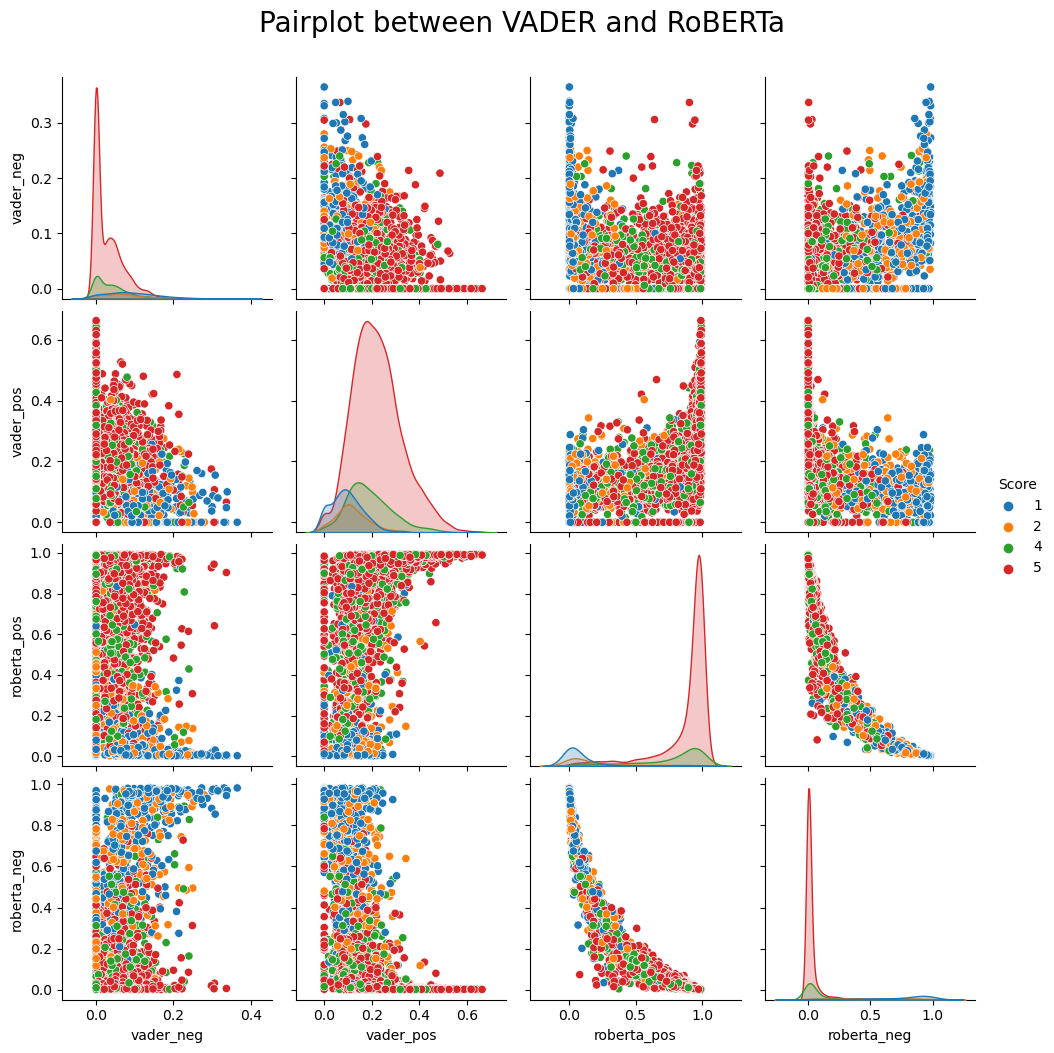

In [76]:
g = sns.pairplot(data = final_df_all,
            vars = ['vader_neg','vader_pos',
                    'roberta_pos', 'roberta_neg'],
            hue = 'Score',
            palette =  'tab10')

g.fig.suptitle("Pairplot between VADER and RoBERTa", y = 1.05, fontsize = 20)

In [139]:
final_df_all.query('lstm_compound >= 0.5')['lstm_compound'].values

array([0.9986508 , 0.99775517, 0.9964848 , ..., 0.9982998 , 0.99878275,
       0.93705326], dtype=float32)

In [ ]:
##Sentiment distribution of the LSTM model

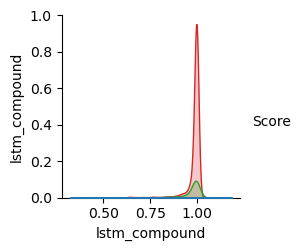

In [140]:
sns.pairplot(data = final_df_all.loc[final_df_all['lstm_compound']>=0.5],
             hue = 'Score',
             vars = ['lstm_compound'],
             palette = 'tab10')

(0.0, 1.0)

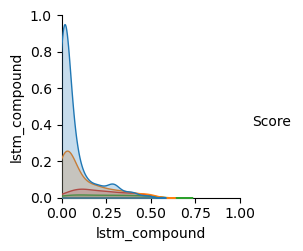

In [141]:
g = sns.pairplot(data = final_df_all.loc[final_df_all['lstm_compound']< 0.5],
             hue = 'Score',
             vars = ['lstm_compound'],
             palette = 'tab10')
g.axes[0,0].set_xlim((0,1))